# Brain data

In [23]:
DATA_DIR = "data/"
N_JOBS = 1
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from utils import implot, load_data
from online.metrics import crop_center_square
from mri.operators import FFT
from online.generator import PartialColumn2DKspaceGenerator, DataOnlyKspaceGenerator
from online.fourier import ColumnFFT

(16, 640, 320) complex128
(320, 320) float32
file_brain_AXFLAIR_200_6002462.h5
1


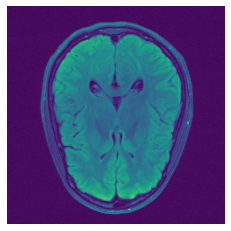

In [24]:
_, real_img, mask_loc, final_mask = load_data(DATA_DIR,1)

real_img = np.complex128(real_img)
# real_img = np.zeros((320,320))
# real_img[130:190,130:190] = 1

implot(real_img)
mask_loc = np.arange(320)
full_k = sp.fft.ifftshift(sp.fft.fft2(sp.fft.fftshift(real_img)))
final_k = full_k

kspace_gen = PartialColumn2DKspaceGenerator(final_k, mask_loc)
kspace_gen2 = DataOnlyKspaceGenerator(final_k, mask_loc)

K_DIM = kspace_gen.shape[-2:]
N_COILS = 1

fourier_op = FFT(mask=kspace_gen.mask,
                 shape=K_DIM,
                 n_coils=N_COILS,
                 n_jobs=N_JOBS)
line_fourier_op = ColumnFFT(shape=K_DIM,
                          n_coils=N_COILS,
                          line_index=0)

idx = 32 # the discrete frequency line to acquire.



In [25]:


%%time
k, mask = kspace_gen[idx]
f = kspace_gen.cols[idx]
fourier_op.mask = mask
fftmask  = fourier_op.op(real_img)[:,f]

CPU times: user 4.64 ms, sys: 1.12 ms, total: 5.76 ms
Wall time: 4.59 ms


In [26]:
%%time
k,f = kspace_gen2[idx]
line_fourier_op.line_index = f
fft_line = line_fourier_op.op(real_img)


CPU times: user 6.2 ms, sys: 722 µs, total: 6.92 ms
Wall time: 3.3 ms


Text(0.5, 1.0, 'absolute error, forward operator')

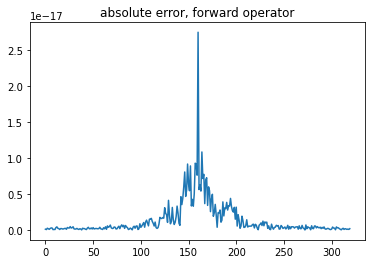

In [27]:
plt.figure()
plt.plot(abs(fftmask-fft_line))
plt.title("absolute error, forward operator")


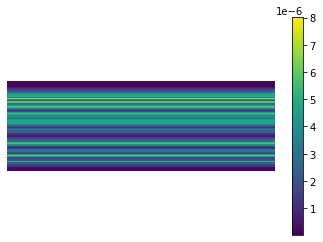

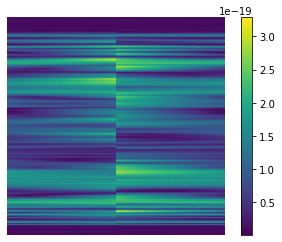

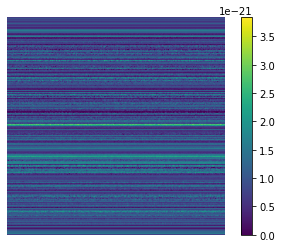

In [28]:
ifftmask = fourier_op.adj_op(fourier_op.op(real_img))
ifft_line = line_fourier_op.adj_op(line_fourier_op.op(real_img))
ifft_line2 = line_fourier_op.auto_adj_op(real_img)

implot(np.concatenate([ifftmask,ifft_line, ifft_line],axis=1),colorbar=True)
implot(abs(ifftmask-ifft_line),colorbar=True)
implot(abs(ifft_line-ifft_line2),colorbar=True)

In [29]:
peak_err = np.zeros(320)
for idx in range(len(peak_err)):
    # fft2
    k, mask = kspace_gen[idx]
    f = kspace_gen.cols[idx]
    fourier_op.mask = mask
    fftmask  = fourier_op.op(real_img)[:,f]
    #fft1.5
    k,f = kspace_gen2[idx]
    line_fourier_op.line_index = f
    goertzel = line_fourier_op.op(real_img)
    peak_err[idx] = np.max(np.abs(goertzel-fftmask))


Text(0.5, 0, 'mask column (starting from center')

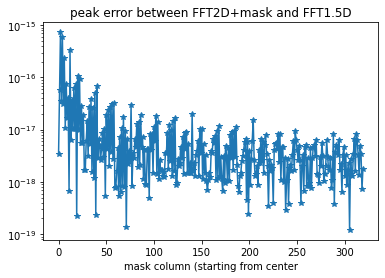

In [30]:
plt.semilogy(peak_err,'-*')
plt.title('peak error between FFT2D+mask and FFT1.5D')
plt.xlabel('mask column (starting from center')

In [31]:
peak_err2 = np.zeros(320)
for idx in range(len(peak_err2)):
    # fft2
    k, mask = kspace_gen[idx]
    f = kspace_gen.cols[idx]
    fourier_op.mask = mask
    ifftmask  = fourier_op.adj_op(fourier_op.op(real_img))
    #fft1.5
    k,f = kspace_gen2[idx]
    line_fourier_op.line_index = f
    igoertzel = line_fourier_op.adj_op(line_fourier_op.op(real_img))
    peak_err2[idx] = np.max(np.abs(igoertzel-ifftmask))


Text(0.5, 0, 'mask column (Center = null frequency)')

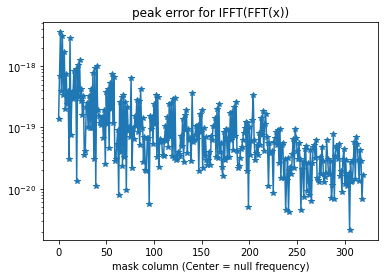

In [32]:
plt.semilogy(peak_err2,'-*')
plt.title('peak error for IFFT(FFT(x))')
plt.xlabel('mask column (Center = null frequency)')

## How does it scale
### Forward operator

In [33]:
import time
sizes = [32,64,128,256,512,1024]
times1 = np.zeros((len(sizes),2))
for n,size in enumerate(sizes):
    ta = 0
    tb = 0
    K_DIM = (size,size)
    mask = np.zeros(K_DIM)
    mask[:,size//2] = 1
    line_fourier_op = ColumnFFT(shape=K_DIM,
                          n_coils=N_COILS,
                          line_index=size//2)
    fourier_op = FFT(mask=mask,
                 shape=K_DIM,
                 n_coils=N_COILS,
                 n_jobs=N_JOBS)
    for k in range(5):
        real_img = np.random.random(K_DIM) + 1j *np.random.random(K_DIM)
        ts = time.perf_counter()
        _ = fourier_op.op(real_img)
        ti = time.perf_counter()
        _ = line_fourier_op.op(real_img)
        tf = time.perf_counter()
        ta += ti-ts
        tb += tf-ti
    times1[n,0] = ta/5
    times1[n,1] = tb/5


Text(0, 0.5, 'time')

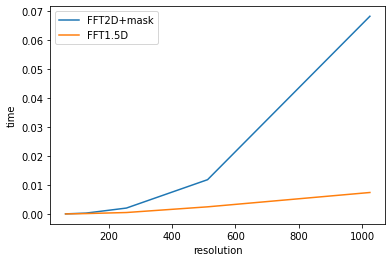

In [34]:
plt.plot(sizes[1:],times1[1:,0],label="FFT2D+mask")
plt.plot(sizes[1:],times1[1:,1],label="FFT1.5D")
plt.legend()
plt.xlabel('resolution')
plt.ylabel('time')

### Backward operator

In [36]:
import time
sizes = [32,64,128,256,512,1024]
times2 = np.zeros((len(sizes),2))
for n,size in enumerate(sizes):
    ta = 0
    tb = 0
    K_DIM = (size,size)
    mask = np.zeros(K_DIM)
    mask[:,size//2] = 1
    line_fourier_op = ColumnFFT(shape=K_DIM,
                      n_coils=N_COILS,
                      line_index=size//2)
    fourier_op = FFT(mask=mask,
             shape=K_DIM,
             n_coils=N_COILS,
             n_jobs=N_JOBS)
    for k in range(5):
        k_ref = np.random.random(K_DIM) + 1j *np.random.random(K_DIM)
        k_ref_mask = k_ref[:,size//2]
        ts = time.perf_counter()
        _ = fourier_op.adj_op(k_ref)
        ti = time.perf_counter()
        _ = line_fourier_op.adj_op(k_ref_mask)
        tf = time.perf_counter()
        ta += ti-ts
        tb += tf-ti
    times2[n,0] = ta/5
    times2[n,1] = tb/5


Text(0, 0.5, 'time')

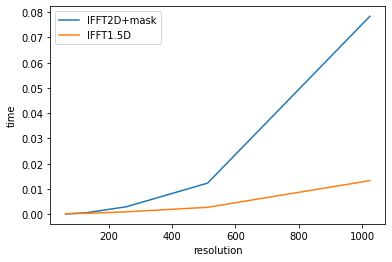

In [37]:
plt.plot(sizes[1:],times2[1:,0],label="IFFT2D+mask")
plt.plot(sizes[1:],times2[1:,1],label="IFFT1.5D")
plt.legend()
plt.xlabel('resolution')
plt.ylabel('time')

### Self-Adjoint operator

In [38]:
import time
sizes = [32,64,128,256,512,1024]
times3 = np.zeros((len(sizes),3))
for n,size in enumerate(sizes):
    ta = 0
    tb = 0
    tc = 0
    K_DIM = (size,size)
    mask = np.zeros(K_DIM)
    mask[:,size//2] = 1
    line_fourier_op = ColumnFFT(shape=K_DIM,
                      n_coils=N_COILS,
                      line_index=size//2)
    fourier_op = FFT(mask=mask,
             shape=K_DIM,
             n_coils=N_COILS,
             n_jobs=N_JOBS)
    for k in range(5):
        real_img = np.random.random(K_DIM) + 1j *np.random.random(K_DIM)
        ts = time.perf_counter()
        _ = fourier_op.adj_op(fourier_op.op(real_img))
        ti = time.perf_counter()
        _ = line_fourier_op.adj_op(line_fourier_op.op(real_img))
        tii = time.perf_counter()
        _ =  line_fourier_op.auto_adj_op(real_img)
        tf = time.perf_counter()
        ta += ti-ts
        tb += tii-ti
        tc += tf-tii
    times3[n,0] = ta/5
    times3[n,1] = tb/5
    times3[n,2] = tc/5

Text(0, 0.5, 'time')

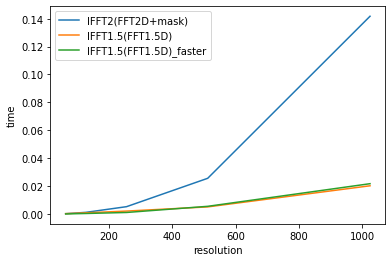

In [39]:
plt.plot(sizes[1:],times3[1:,0],label="IFFT2(FFT2D+mask)")
plt.plot(sizes[1:],times3[1:,1],label="IFFT1.5(FFT1.5D)")
plt.plot(sizes[1:],times3[1:,2],label="IFFT1.5(FFT1.5D)_faster")
plt.legend()
plt.xlabel('resolution')
plt.ylabel('time')